In [1]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim

import matplotlib.pyplot as plt
plt.rc('font', size=16)
import time

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### load AlexNet with pretrained weights from ImageNet

In [2]:
import torchvision.models as models

alexnet = models.alexnet(pretrained=True)


In [3]:
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [4]:
X = torch.randn(1, 3, 224, 224)#.to(device)

print('Input shape:\t', X.shape)

for layer in alexnet.features:
    X=layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Input shape:	 torch.Size([1, 3, 224, 224])
Conv2d output shape:	 torch.Size([1, 64, 55, 55])
ReLU output shape:	 torch.Size([1, 64, 55, 55])
MaxPool2d output shape:	 torch.Size([1, 64, 27, 27])
Conv2d output shape:	 torch.Size([1, 192, 27, 27])
ReLU output shape:	 torch.Size([1, 192, 27, 27])
MaxPool2d output shape:	 torch.Size([1, 192, 13, 13])
Conv2d output shape:	 torch.Size([1, 384, 13, 13])
ReLU output shape:	 torch.Size([1, 384, 13, 13])
Conv2d output shape:	 torch.Size([1, 256, 13, 13])
ReLU output shape:	 torch.Size([1, 256, 13, 13])
Conv2d output shape:	 torch.Size([1, 256, 13, 13])
ReLU output shape:	 torch.Size([1, 256, 13, 13])
MaxPool2d output shape:	 torch.Size([1, 256, 6, 6])


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [5]:
alexnet.features[0].weight.data.shape

torch.Size([64, 3, 11, 11])

In [6]:
def get_weights(model, layerID, in_channelID=None, out_channelID=None):
    '''plot filters of channels 
        If in_channelID  is given, plot filters of all out_channels (at fixed in_channelID ).
        If out_channelID is given, plot filters of all in_channels  (at fixed out_channelID).
    '''
    
    if in_channelID is not None:
        layerW = model[layerID].weight.data[:,in_channelID,:,:].cpu().numpy()
    if out_channelID is not None:
        layerW = model[layerID].weight.data[out_channelID,:,:,:].cpu().numpy()
    
    return layerW

def view_3D_cubes(cube3D, Ncols, Nrows, figsize, cmap='Greys'):
    
    fig, axs = plt.subplots(Nrows, Ncols, figsize=figsize)
    plt.subplots_adjust(hspace=0.1, wspace=0.1)
    
    for i in range(Nrows):    
        for j in range(Ncols):
    
            axs[i,j].imshow(cube3D[i*Ncols+j], cmap=cmap)
            axs[i,j].axis('off')
    return fig, axs

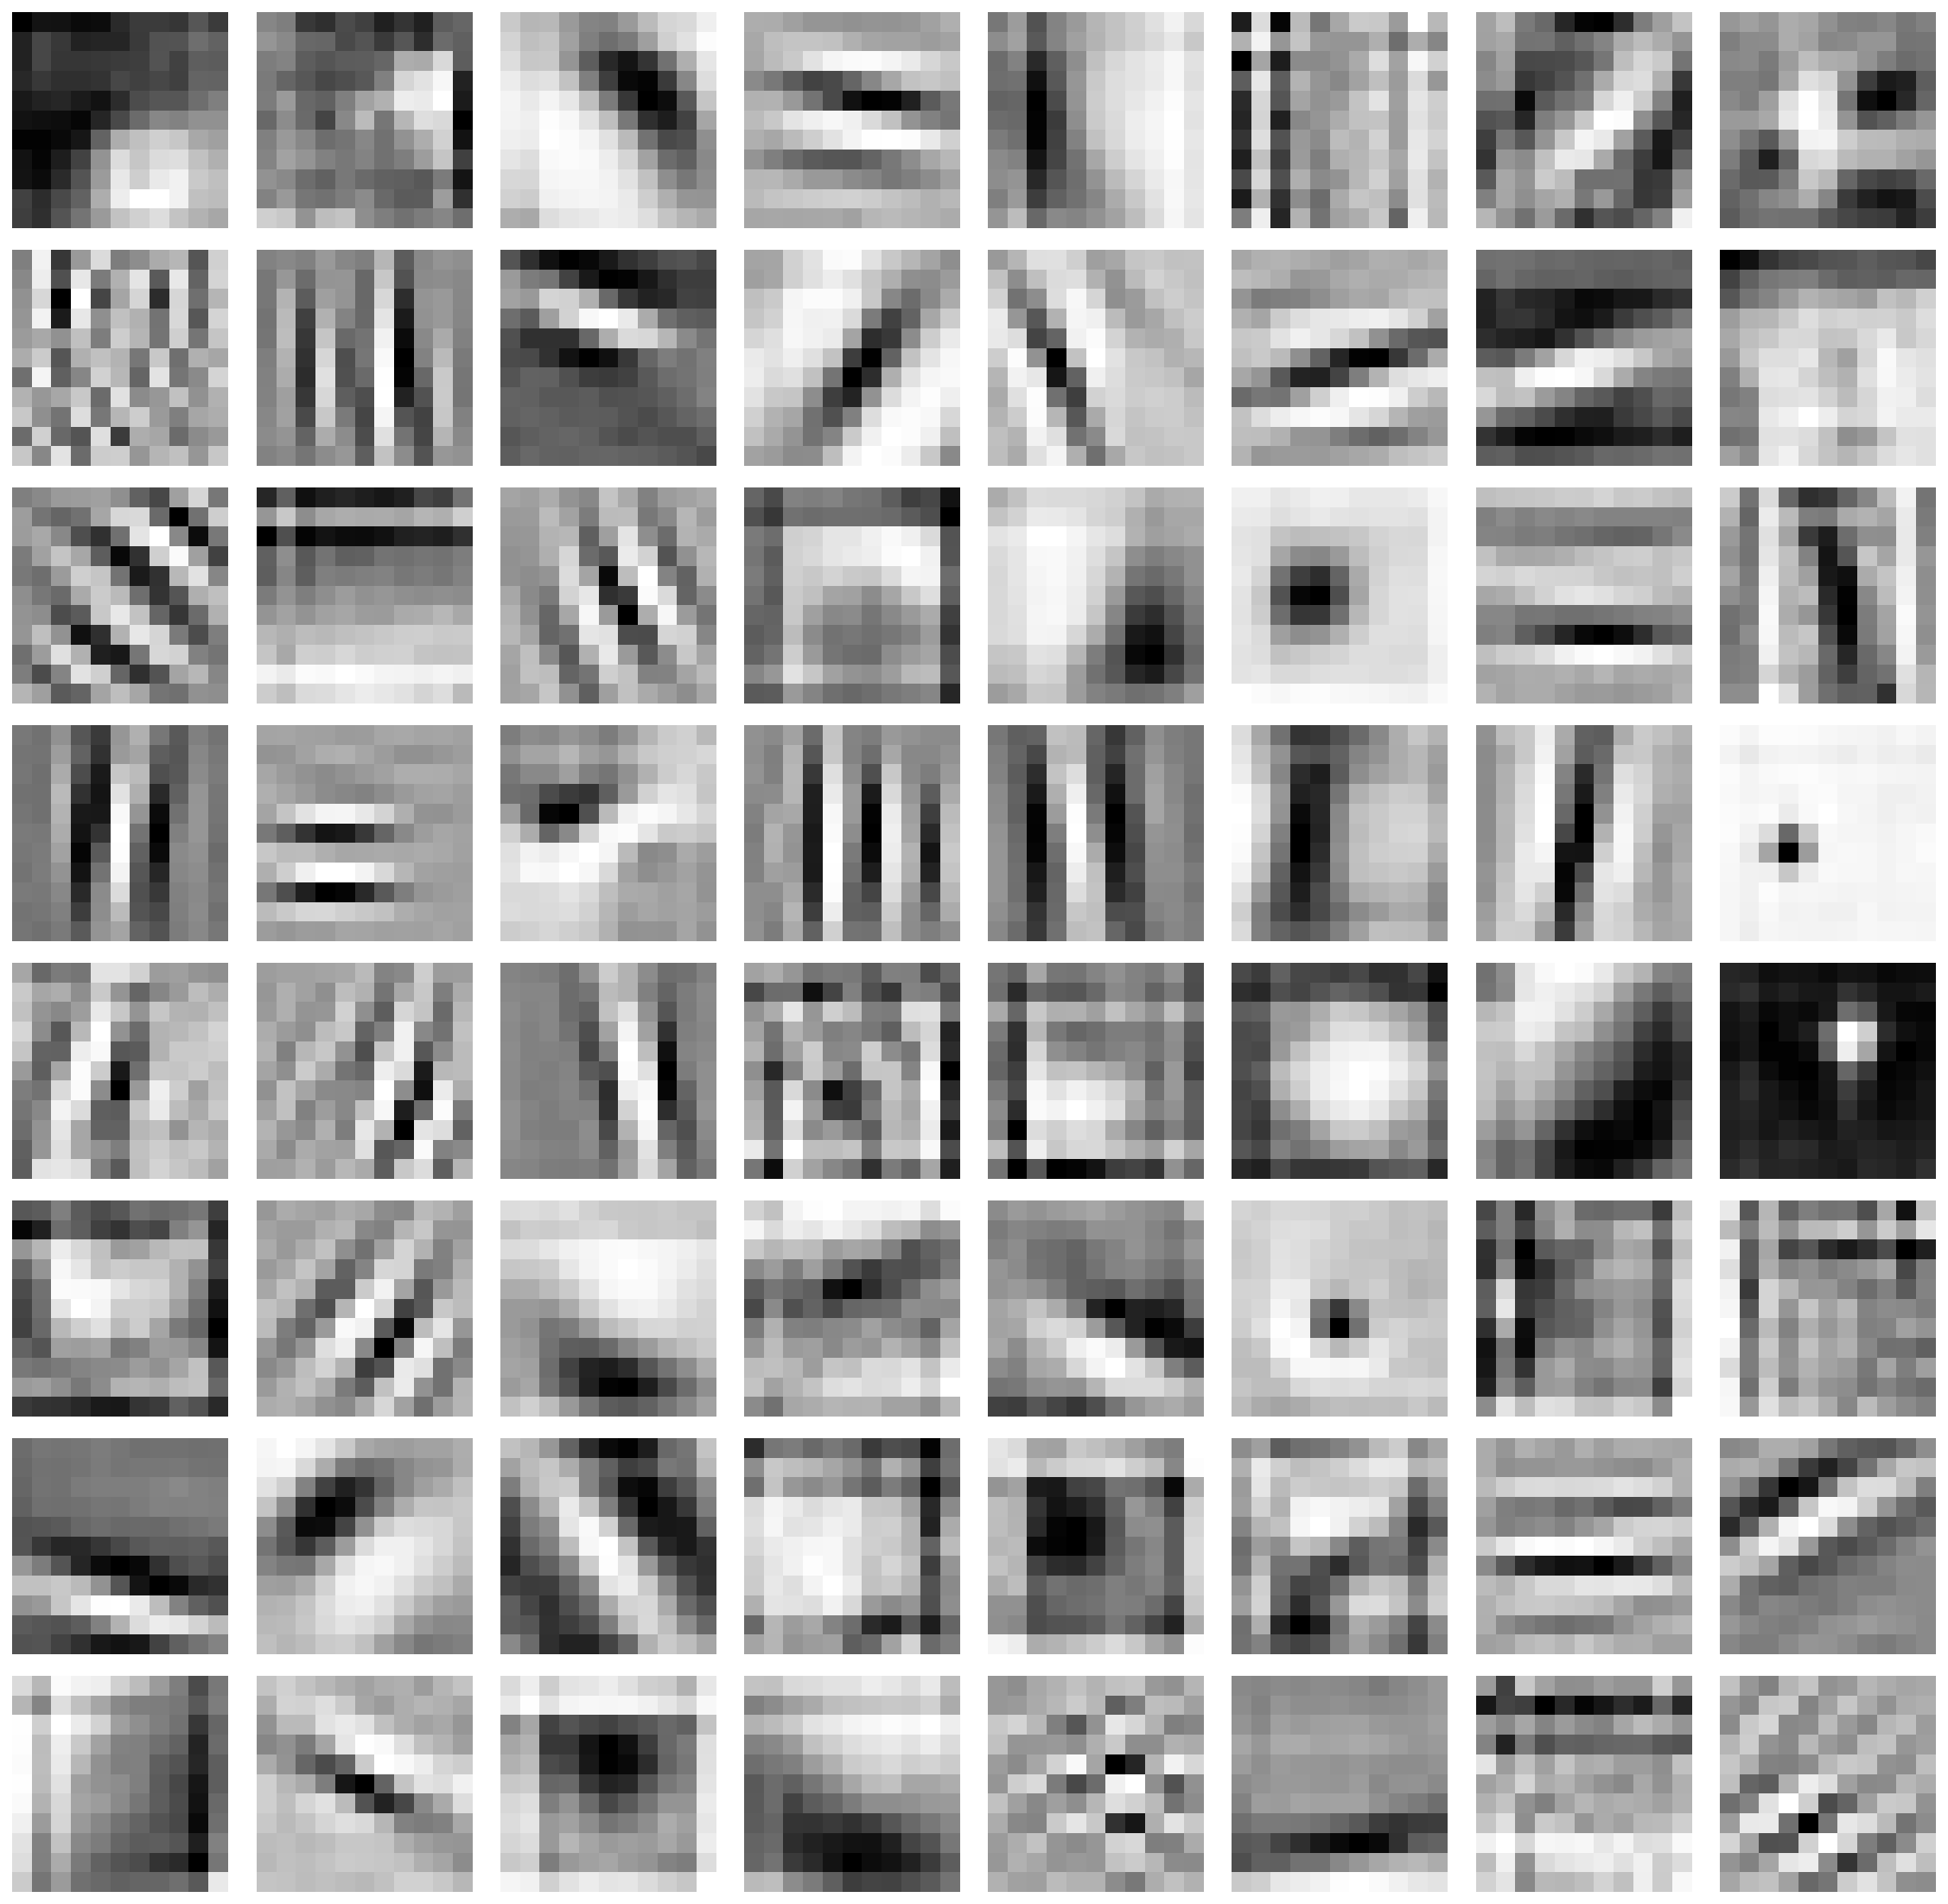

In [7]:
layerW = get_weights(alexnet.features, 0, in_channelID=0)
_,__ = view_3D_cubes(layerW, Ncols=8, Nrows=8, figsize=(20,20), cmap='Greys')

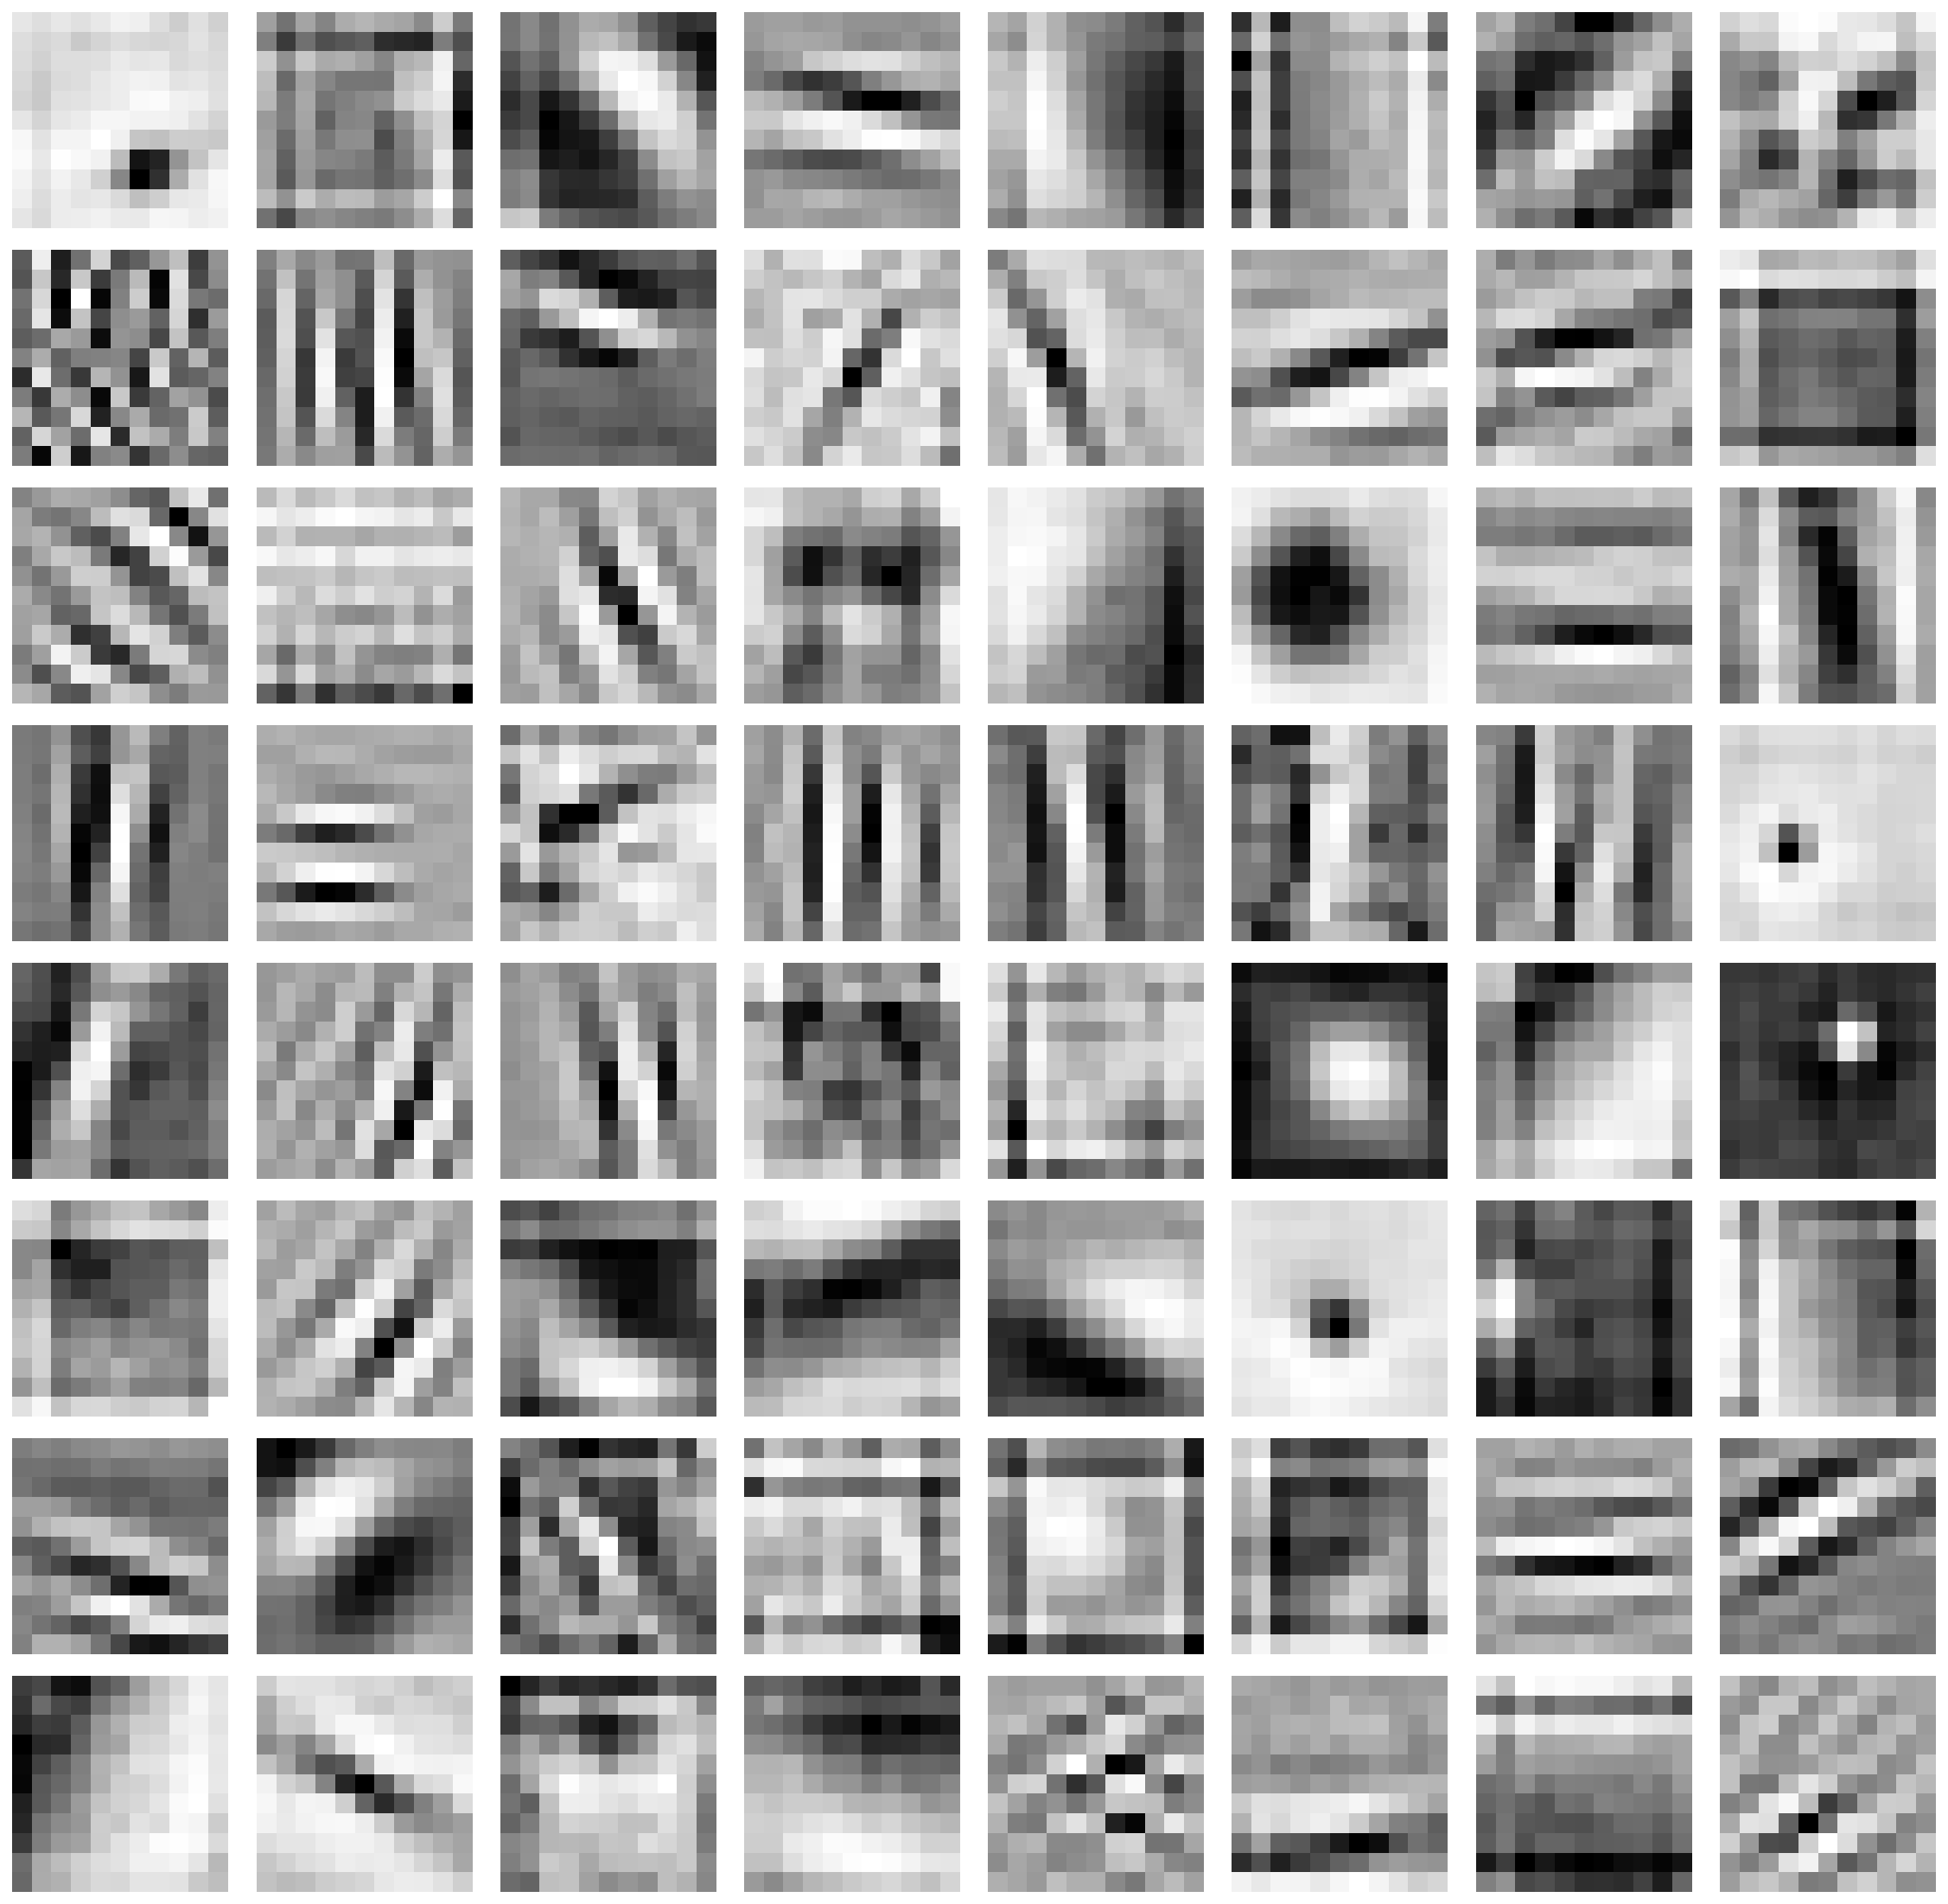

In [8]:
layerW = get_weights(alexnet.features, 0, in_channelID=2)
_,__ = view_3D_cubes(layerW, Ncols=8, Nrows=8, figsize=(20,20), cmap='Greys')

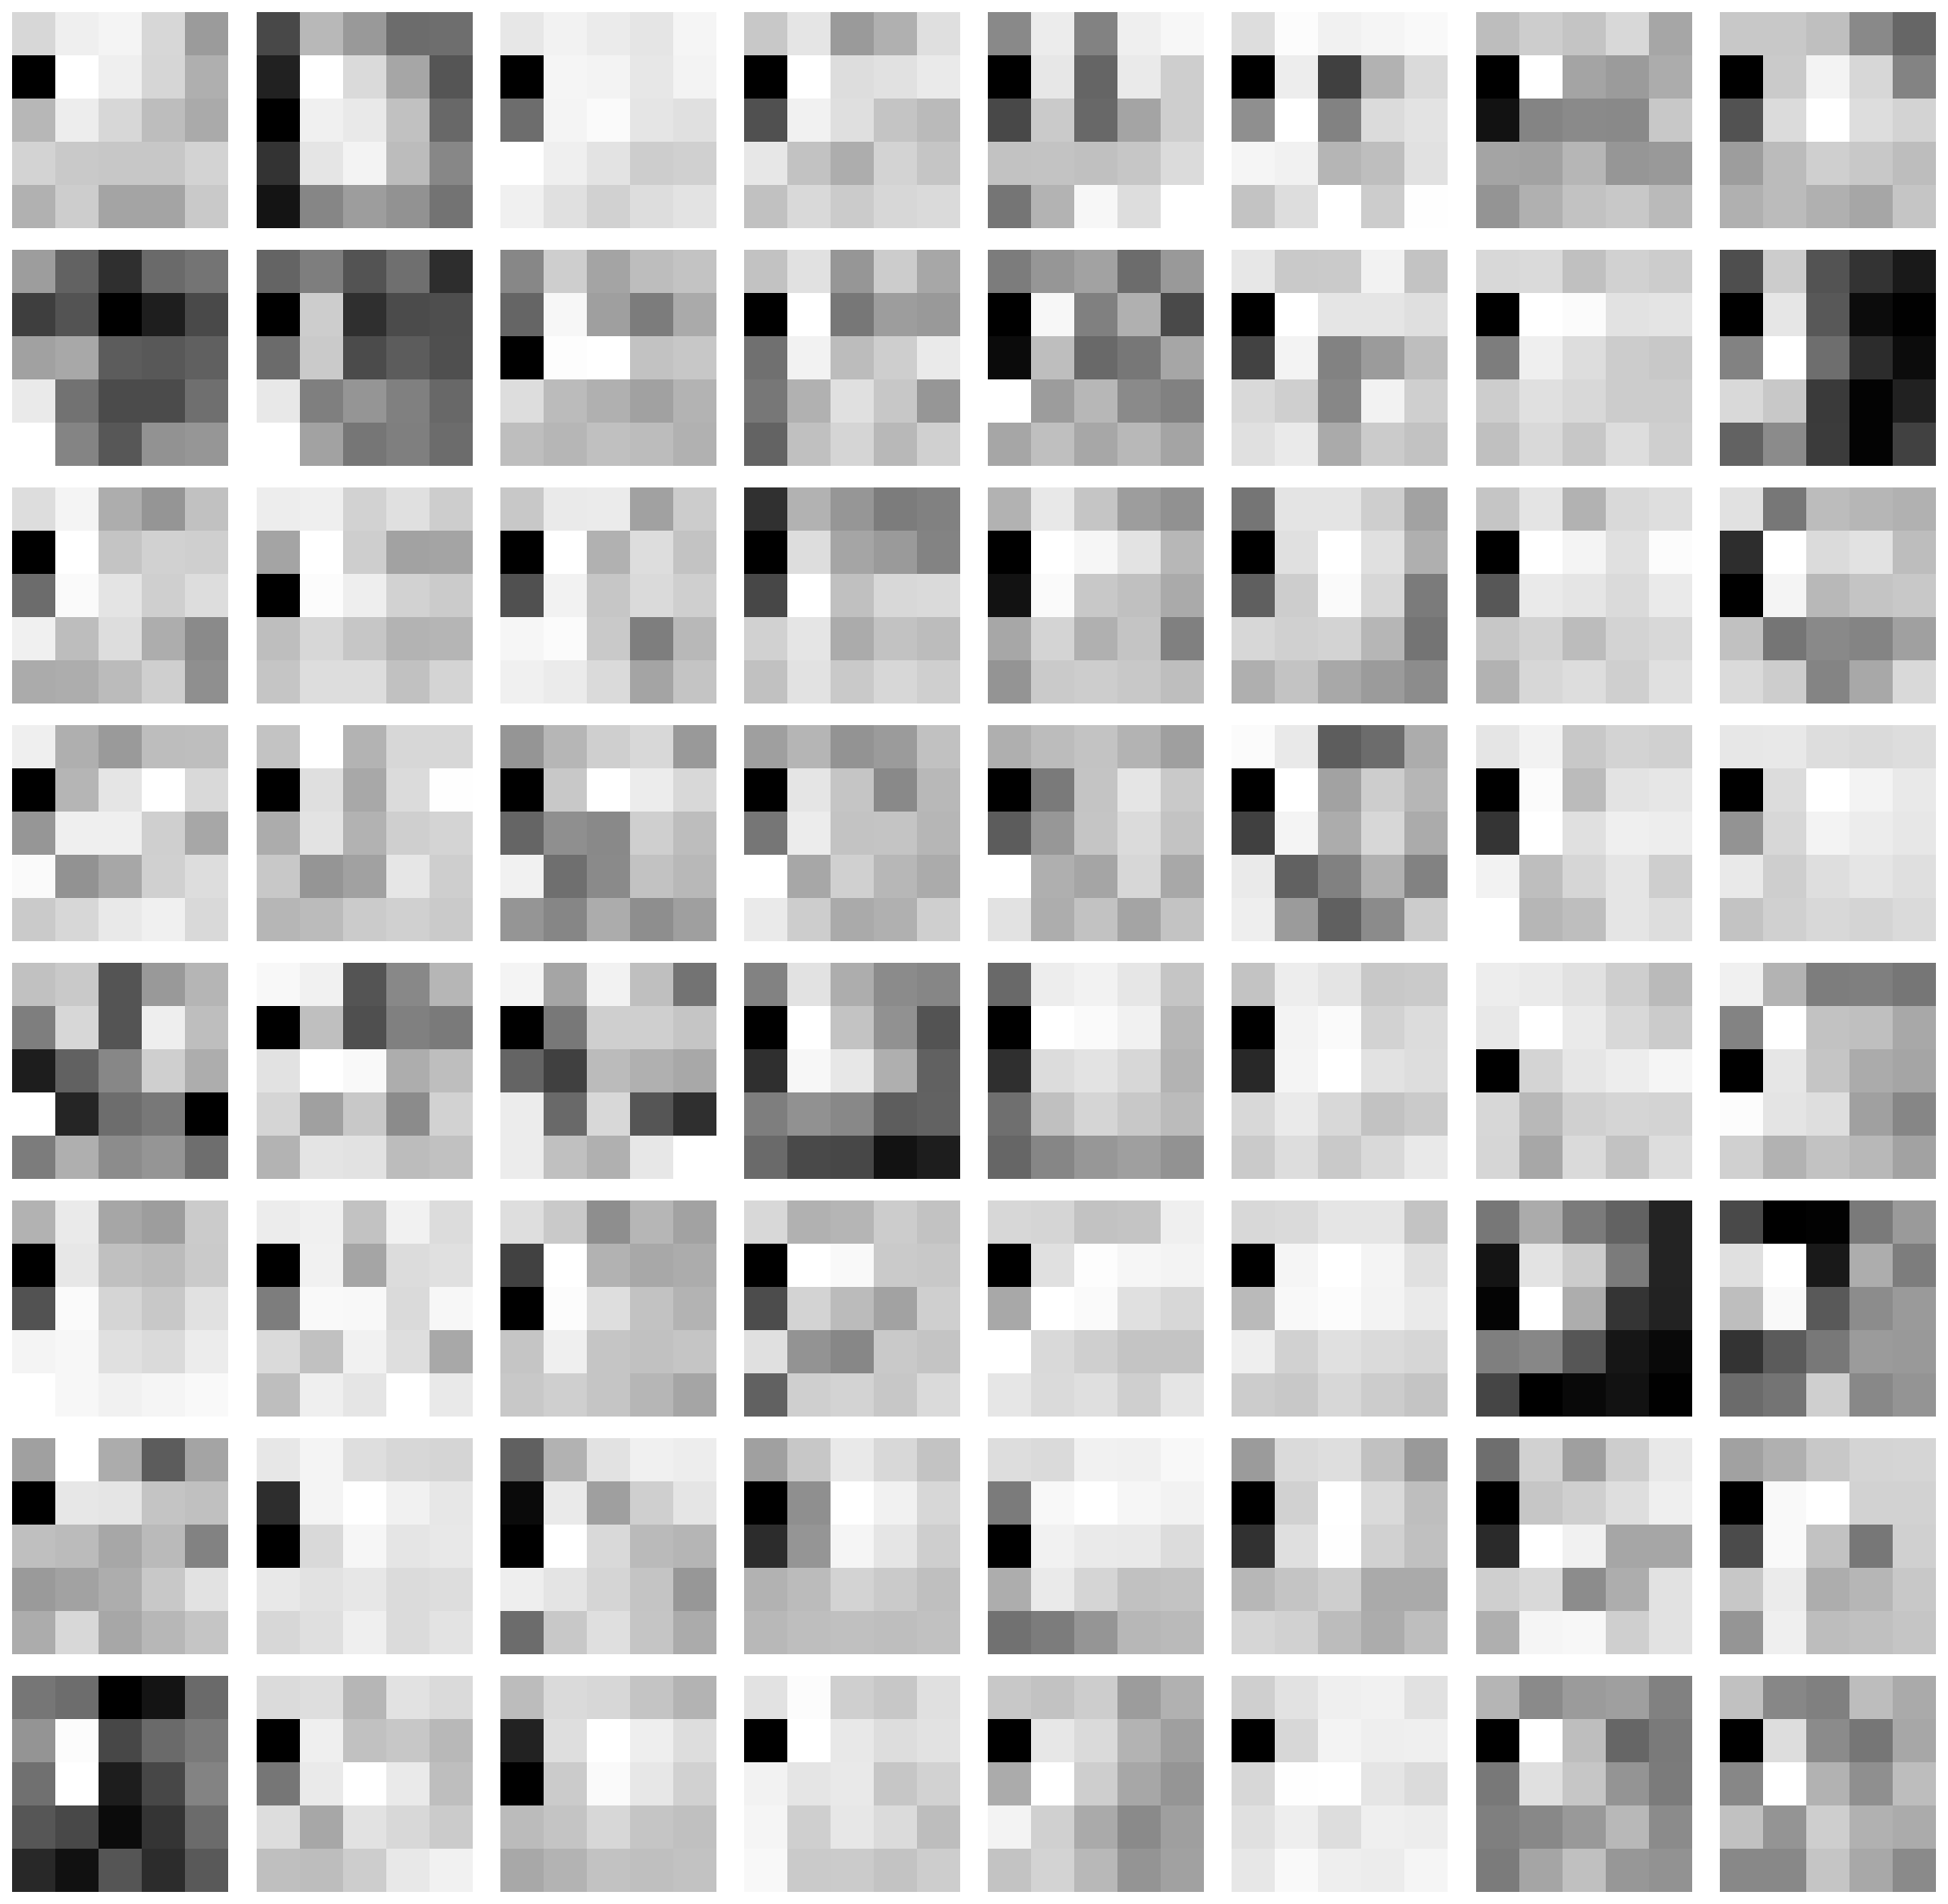

In [9]:
layerW = get_weights(alexnet.features, 3, out_channelID=2)
_,__ = view_3D_cubes(layerW, Ncols=8, Nrows=8, figsize=(20,20), cmap='Greys')

### Take the pretrained AlexNet kernel and applied on fashion-MNIST dataset

In [10]:
### load Fashion-MNIST data

transform = transforms.Compose([transforms.Resize([224, 224]),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor()])

fmnist_train = datasets.FashionMNIST(
    root="../../../data", train=True, transform=transform, download=True)
fmnist_test = datasets.FashionMNIST(
    root="../../../data", train=False, transform=transform, download=True)

/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [11]:
layerW = get_weights(alexnet.features, 0, in_channelID=0)

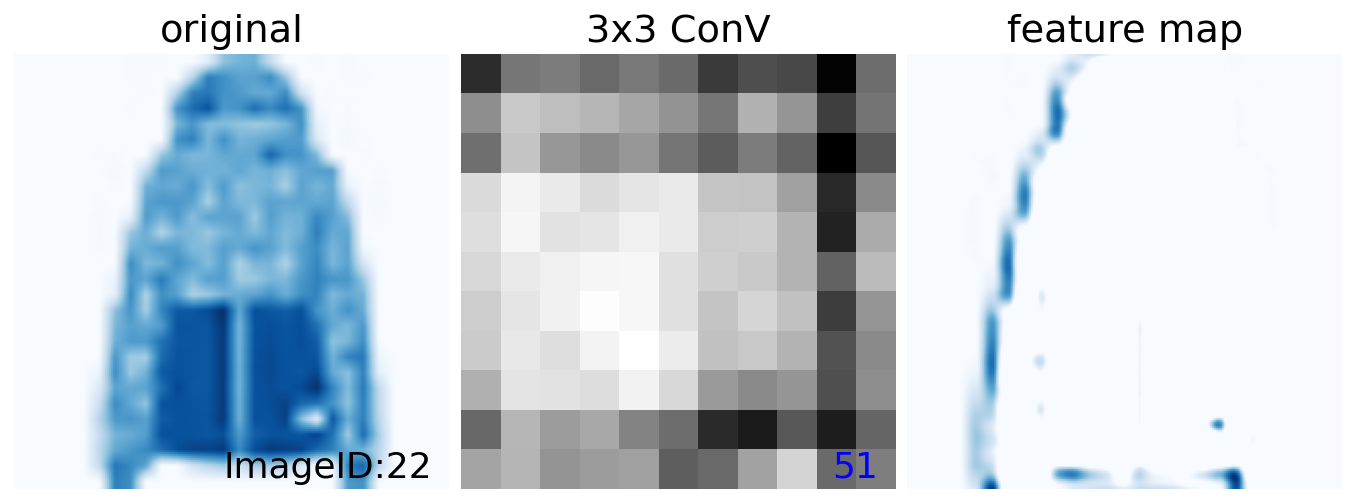

In [12]:
channelID = 51

conv2d = nn.Conv2d(1, 1, kernel_size=(3, 3), bias=False)
conv2d.weight.data = torch.tensor(layerW[channelID]).view(1, 1, 11, 11)


imageID = 22
X, _ = fmnist_train.__getitem__(imageID)
outX = conv2d(X.unsqueeze(dim=0))  # Convolution
outX = nn.ReLU()(outX)             # Apply ReLU

###############

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
plt.subplots_adjust(hspace=0.001, wspace=0.001)
plt.rc('font', size=16)
axes[0].imshow(X.squeeze().numpy(), cmap='Blues')
axes[1].imshow(layerW[channelID], cmap='Greys')
axes[2].imshow(outX.squeeze().detach().numpy(), cmap='Blues')

axes[0].text(0.96, 0.01, f'ImageID:{imageID}',
                           verticalalignment='bottom', horizontalalignment='right',
                           transform=axes[0].transAxes,
                           color='k', fontsize=18)

axes[1].text(0.96, 0.01, f'{channelID}',
                           verticalalignment='bottom', horizontalalignment='right',
                           transform=axes[1].transAxes,
                           color='b', fontsize=18)

axes[0].set_title('original')
axes[1].set_title('3x3 ConV')
axes[2].set_title('feature map')

for i in range(3):
    axes[i].axis('off')

## Transfer Learning : change the final layer of AlexNet

In [13]:
alexnet_TL = models.alexnet(pretrained=True)

alexnet_TL

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [14]:
alexnet_TL.classifier[6] = nn.Linear(4096, 10)

In [15]:
alexnet_TL

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [16]:
# count total network parameters (before freeze the parameters)
print('Total network parameters :', sum(param.numel() for param in alexnet_TL.parameters() if param.requires_grad))

Total network parameters : 57044810


In [19]:
# Freeze the parameters in the CNN part
for param in alexnet_TL.features.parameters():
    param.requires_grad = False

In [20]:
# count total network parameters (before freeze the parameters)
print('Total network parameters :', sum(param.numel() for param in alexnet_TL.parameters() if param.requires_grad))

Total network parameters : 54575114
